# 作业：Dino Fun World 时间序列分析

当地游乐园 Dino Fun World 的管理员要求你（他们的数据分析师之一）为他们的游乐园执行三个数据分析任务。这些任务将涉及了解、分析和绘制游乐园提供给你使用的参入量数据。他们以数据库的形式提供数据，如下所述。

### 提供的数据库

游乐园管理员提供的数据库可被任何 SQL 数据库读取。我们推荐 sqlite3 数据库。该数据库包含三个表格，分别为 “checkin”、“attraction” 和 “sequences”。每个表中所含的信息如下所示：

`checkin (登记)`:
    - 说明：游乐园当天所有游客的登记数据。该数据包括两类登记数据: 推测登记数据和实际登记数据。
    - 字段：visitorID, timestamp, attraction, duration, type。
`attraction (景点)`:
    - 游乐园景点包括相应的景点编号、名称、区域、类别和类型。区域包括 VAST 挑战地图，如过山车场区 (Coaster Alley)、 冻原之地 (Tundra Land) 等等。类别包括惊险飞车 (Thrill Rides)、儿童碰碰车 (Kiddie Rides) 等。类型包括户外过山车 (Outdoor Coaster)、其他游乐项目 (Other Ride) 、旋转木马 (Carussel) 等等。
    - 字段：attractionID, name, region, category, type
`sequences (登记序列)`:
    - 游客登记序列。这些序列显示每五分钟进入游乐场的游客位置。如果游客尚未进入游乐场，则该时间段内序列的值为 0 。如果游客在游乐场中，则序列显示游客时间上最近登记的景点，直到该遊客登记其他景点，或离开游乐场。
    - 字段：visitorID, sequence
    
数据库名称为“dinofunworld.db”，可以在 Jupyter Notebook 环境（即 readonly/dinofunworld.db）中的只读目录中找到

### 作业

1：游乐园管理员对数据窗口中游乐项目“Atmosfear”的参入量表示担心。为了减轻他们的压力，他们要求你创建一个此游乐项目总参入量的控制图。使用提供的数据，创建一个控制图，以显示参入量、平均值以及一到两个标准差的标准差带。

2：游乐园的一些管理员在解释“Atmosfear”参入量的控制图时遇到困难，因此他们要求你除了提供在上一个问题中创建的控制图外，还要提供参入量的移动平均图。在此情况下，他们要求你针对移动平均窗口的大小使用 50 个样本。

3：为了提供有关图表的选项，游乐园管理员还要求你提供一个包含 50 个样本的移动平均窗口，其中通过相同的“Atmosfear”参入量数据使用指数加权（即指数加权移动平均值）计算平均值。

In [83]:
# 导入用到的工具包
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# 连接数据库
conn = sqlite3.connect("./dinofunworld.db")
c = conn.cursor()

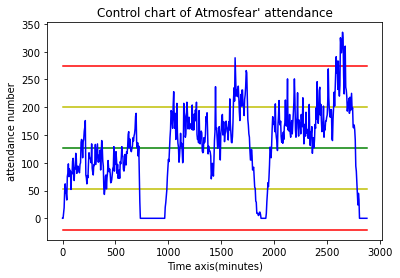

In [86]:
# 1:游乐园管理员对数据窗口中游乐项目“Atmosfear”的参入量表示担心。
# 为了减轻他们的压力，他们要求你创建一个此游乐项目总参入量的控制图。
# 使用提供的数据，创建一个控制图，以显示参入量、平均值以及一到两个标准差的标准差带。

# 分析：查出atmosfear的id和所有游客的sequence数据
# 将游客的sequence数据与atmosfear的id进行比对和统计
# 计算atmosfear 每个时间点的参入量和平均值以及标准差
# 绘制atmosfear参入量的时间分布控制图
c.execute("SELECT AttractionID, Name FROM attraction WHERE Name = 'Atmosfear';")
atmosfear = c.fetchone()
atmosfearId = atmosfear[0]

c.execute("SELECT sequence FROM sequences;")
sequences_list = c.fetchall()
sequences_frame = pd.DataFrame.from_records(sequences_list, columns=['sequence'])
# 标记Atmosfear attendance的数组
sequences_frame['atmosfear_attendance_array'] = sequences_frame['sequence'].apply(lambda sequence: [1 if atmosfearId == int(attendance) else 0 for attendance in sequence.split('-')])

# 统计Atmosfear attendance数量的数组
sum_atmosfear_attendance_array = np.sum(sequences_frame['atmosfear_attendance_array'].values.tolist(), axis=0)
# 平均值
mean = np.nanmean(sum_atmosfear_attendance_array)
# 标准差
std = np.nanstd(sum_atmosfear_attendance_array)
# x轴label,序列是每五分钟的取值
plot_x_axis_list = range(0, len(sum_atmosfear_attendance_array)*5, 5)
# 控制上限和控制下限
plt.plot(plot_x_axis_list, [mean+2*std]*len(sum_atmosfear_attendance_array), 'r-')
plt.plot(plot_x_axis_list, [mean-2*std]*len(sum_atmosfear_attendance_array), 'r-')
plt.plot(plot_x_axis_list, [mean+std]*len(sum_atmosfear_attendance_array), 'y-')
plt.plot(plot_x_axis_list, [mean-std]*len(sum_atmosfear_attendance_array), 'y-')
# 平均值中心
plt.plot(plot_x_axis_list, [mean]*len(sum_atmosfear_attendance_array), 'g-')
plt.plot(plot_x_axis_list, sum_atmosfear_attendance_array, 'b-')
plt.ylabel('attendance number')
plt.xlabel('Time axis(minutes)')
plt.title('Control chart of Atmosfear\' attendance')
plt.show()

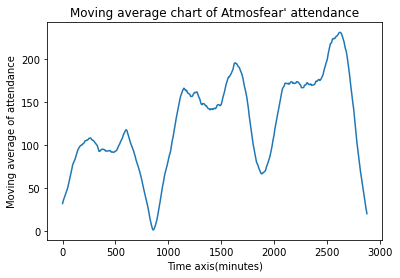

In [81]:
# 2：游乐园的一些管理员在解释“Atmosfear”参入量的控制图时遇到困难，
# 因此他们要求你除了提供在上一个问题中创建的控制图外，还要提供参入量的移动平均图。
# 在此情况下，他们要求你针对移动平均窗口的大小使用 50 个样本。

# 分析：绘制移动平均图，需要计算参入量的范围内动态平均值


# 样本数为50，使用卷积函数计算移动平均值
sample_size = 50
plt.plot(plot_x_axis_list, np.convolve(sum_atmosfear_attendance_array, np.ones(sample_size)/sample_size, 'same') )
plt.ylabel('Moving average of attendance')
plt.xlabel('Time axis(minutes)')
plt.title('Moving average chart of Atmosfear\' attendance')
plt.show()

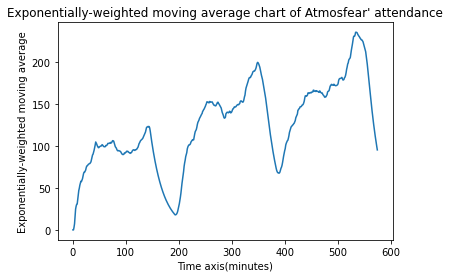

In [91]:
# 3：为了提供有关图表的选项，游乐园管理员还要求你提供一个包含 50 个样本的移动平均窗口，
# 其中通过相同的“Atmosfear”参入量数据使用指数加权（即指数加权移动平均值）计算平均值。


# 分析：绘制指数加权移动平均图，使用pandas的函数计算指数加权移动平均值
sum_atmosfear_attendance_frame = pd.DataFrame(data=sum_atmosfear_attendance_array)
sum_atmosfear_attendance_ema = sum_atmosfear_attendance_frame.ewm(span=sample_size).mean()
plt.plot(sum_atmosfear_attendance_ema)
plt.ylabel('Exponentially-weighted moving average')
plt.xlabel('Time axis(minutes)')
plt.title('Exponentially-weighted moving average chart of Atmosfear\' attendance')
plt.show()